In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Epoch 1/50
202/202 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.2451 - loss: nan - val_accuracy: 0.2423 - val_loss: nan
Epoch 2/50
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2442 - loss: nan - val_accuracy: 0.2423 - val_loss: nan
Epoch 3/50
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2396 - loss: nan - val_accuracy: 0.2423 - val_loss: nan
Epoch 4/50
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.2423 - loss: nan - val_accuracy: 0.2423 - val_loss: nan
Epoch 5/50
202/202 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.2487 - loss: nan - val_accuracy: 0.2423 - val_loss: nan
Epoch 6/50
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.2449 - loss: nan - val_accuracy: 0.2423 - val_loss: nan
Epoch 7/50
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2355 - loss: nan - val_accuracy: 0.2423 - val_loss: nan
Epoch 8/50
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.2349 - loss: nan - val_accuracy: 0.2423 - val_loss: nan
Epoch 9/50
202/202 ━━━━━

Model training complete and saved as 'dnn_with_attention_model.h5'
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2458 - loss: nan
Validation Loss: nan
Validation Accuracy: 0.2423


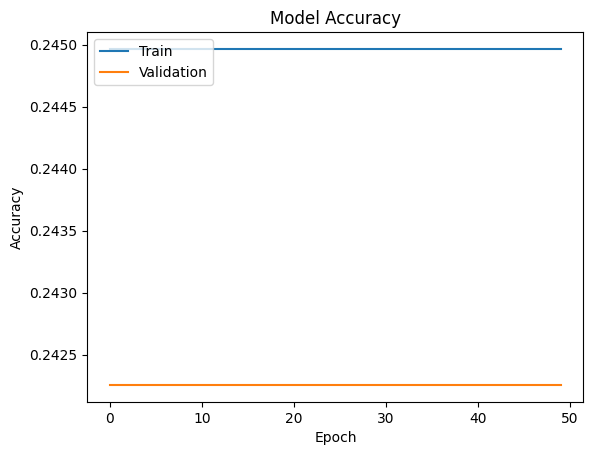

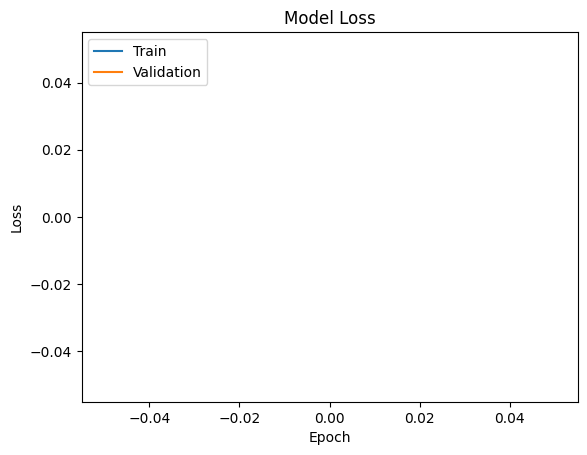

In [11]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Multiply, Activation, Reshape, Flatten
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.pyplot as plt

# Attention Mechanism for Tabular Data
def attention_block(inputs):
    # Learn attention weights
    attention_weights = Dense(inputs.shape[-1], activation='softmax')(inputs)  # Softmax to get weights summing to 1
    # Apply attention weights to the inputs
    attention_output = Multiply()([inputs, attention_weights])
    return attention_output

# Build a DNN model with Attention
def build_dnn_with_attention(input_shape, num_classes):
    inputs = Input(shape=(input_shape,))

    # Feature extraction layers
    x = Dense(128, activation='relu')(inputs)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    x = Dense(64, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    # Apply attention mechanism
    attention_output = attention_block(x)

    # Additional layers after attention
    x = Dense(32, activation='relu')(attention_output)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    # Output layer
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

# Load and preprocess dataset
def load_and_preprocess_data(train_path, test_path):
    if not os.path.exists(train_path):
        raise FileNotFoundError(f"Train file not found: {train_path}")

    train_data = pd.read_csv(train_path)

    # Rename 'Segmentation' column to 'label'
    train_data.rename(columns={'Segmentation': 'label'}, inplace=True)

    # Convert categorical columns to numerical values
    categorical_columns = ['Gender', 'Ever_Married', 'Graduated', 'Profession', 'Var_1', 'Spending_Score']
    label_encoders = {}
    for col in categorical_columns:
        label_encoders[col] = LabelEncoder()
        train_data[col] = label_encoders[col].fit_transform(train_data[col].astype(str))

    # Normalize numerical columns
    numerical_columns = ['Age', 'Work_Experience', 'Family_Size']
    scaler = StandardScaler()
    train_data[numerical_columns] = scaler.fit_transform(train_data[numerical_columns])

    # Encode labels properly
    label_encoder = LabelEncoder()
    train_data['label'] = label_encoder.fit_transform(train_data['label'])

    # Extract features and labels
    X = train_data.drop(columns=['ID', 'label']).values
    y = train_data['label'].values

    # One-hot encode labels
    num_classes = len(np.unique(y))
    y = to_categorical(y, num_classes=num_classes)

    # Split into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    return X_train, X_val, y_train, y_val, X.shape[1], num_classes

# Paths to dataset
train_path = "/content/drive/MyDrive/Customer segmentation/train.csv"
test_path = "/content/drive/MyDrive/Customer segmentation/test.csv"

# Load and preprocess data
try:
    X_train, X_val, y_train, y_val, input_shape, num_classes = load_and_preprocess_data(train_path, test_path)

    # Build model with attention
    model = build_dnn_with_attention(input_shape, num_classes)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Train model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=50,
        batch_size=32
    )

    # Save trained model
    model.save("dnn_with_attention_model.h5")
    print("Model training complete and saved as 'dnn_with_attention_model.h5'")

    # Evaluate model
    val_loss, val_accuracy = model.evaluate(X_val, y_val)
    print(f"Validation Loss: {val_loss:.4f}")
    print(f"Validation Accuracy: {val_accuracy:.4f}")

    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

except (FileNotFoundError, KeyError, ValueError) as e:
    print(f"Error: {e}")